# Práctico 6 - Procesamiento Digital de Imágenes

In [1]:
#%% Importación de Libs
import imageio.v2 as imageio
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft,ifft,fft2,ifft2,fftshift
from skimage.feature import canny
#%matplotlib inline

In [2]:
#%% definición de funciones auxiliares
debug = 0
MAT_RGB2YIQ = np.array([[0.299, 0.587, 0.114],
                        [0.595716,-0.274453,-0.321263],
                        [0.211456,-0.522591, 0.311135]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, MAT_RGB2YIQ)

def yiq2rgb(img):
    return apply_matrix(img, np.linalg.inv(MAT_RGB2YIQ))

def clampeoL(img):
    img[img>=1] = 1;
    img[img<=0] = 0;
    return img
# -----------------------------------------------------------------------------

def kernel(name,N):
# ------------- pasa bajos -------------  
    if name == 'box':
        pulso=np.ones((1,N))
        box=pulso.T*pulso
        return box/box.sum()
    
    elif name == 'circle':
        circle=np.zeros((N,N));
        for i in range (N):
            x=i-(N-1)/2
            for j in range(N):
                y=j-(N-1)/2
                # image circle
                circle[i,j]=1 if (x**2+y**2)<=(N/2)**2  else 0        
        return circle/circle.sum()        
  
    elif name == 'bartlett':
        pulso=np.ones( (1,int((N+1)/2)) )
        pulso=signal.convolve(pulso, pulso)
        bart=pulso.T*pulso
        return bart/bart.sum()
    
    elif name=='gausiano':
        x=np.ones((1,2))
        for ord in range(3,N+1):
            xp=np.ones((1,x.size+1))
            for n in range(1,x.size):
                xp[0][n]=x[0][n-1]+x[0][n]
            x = xp
        gausiano=x.T*x    
        return gausiano/gausiano.sum()
    
# ------------- pasa altos -------------          
    elif name == 'laplaciano':
        if N==4:
            pa = np.array([[0,-1,0],[-1,4,-1],[0,-1,0]]);
            return pa/pa.max();

        elif N==8:
            pa = np.array([[-1,-1,-1],[-1,8,-1],[-1,-1,-1]])
            return pa/pa.max();
        else:
            print('Para el filtro laplaciano el orden debe ser o 4 u 8')

    elif name == 'dog':
        ker1=(N^2)*kernel('gausiano',N)
        ker1=ker1/ker1.min();
        
        N=N-2;
        ker2=(N^2)*kernel('gausiano',N)
        ker2=ker2/ker2.min();
        K=int(ker1.sum()/ker2.sum())
        ker2=K*kernel_pads(ker2,1)
        dog=ker2-ker1;
        return dog
    
    else:
        print('error nombre kernel')

def kernel_pads(kernel,Npads):
    Nker = kernel.shape[0];
    kernel_pads = np.zeros((2*Npads+Nker,2*Npads+Nker));
    for i in range(Nker):
        for j in range(Nker):
            kernel_pads[i+Npads,j+Npads] = kernel[i,j];
    return kernel_pads
# -----------------------------------------------------------------------------
def conv2d_bin(img,kernel,fcn):
    rows, cols = img.shape
    N, _ = kernel.shape
    imgFilter = np.zeros(img.shape)
    guarda = round((N-1)/2)
    #t1 = time.perf_counter()
    for i in range(guarda,rows-guarda):
        for j in range(guarda,cols-guarda):
           
            I=img[i-guarda:i-guarda+N,j-guarda:j-guarda+N]
            imgFilter[i,j]=fcn(I[kernel])
    return imgFilter

# Operaciones morfológicas
Primeros pasitos... jugando con
1. canny
2. operación de dilatación


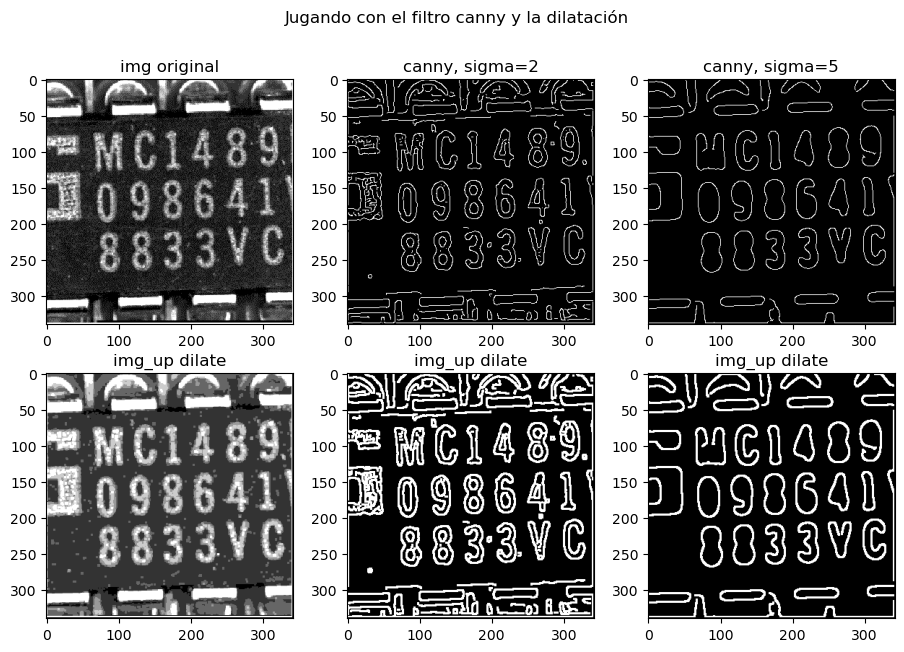

In [3]:
#%%
# -----------------------------------------------------------------------------    
# Seteo inicial
se = kernel('box',3) > 0; # elemento estructurante
s1 = 2 # para el filtro canny
s2 = 5 # para el filtro canny
fcn=np.max # dilatación

img_gray_cam = imageio.imread('imageio:camera.png')/255
img_gray_chip = imageio.imread('chip.gif')[:,:,0]/255
img_gray = img_gray_chip;
img_bin1 = canny(img_gray, sigma=s1); 
img_bin2 = canny(img_gray, sigma=s2)


fig1, ax1 = plt.subplots(2, 3, figsize=(11,7))
ax1[0][0].imshow(img_gray, 'gray'); ax1[0][0].set_title('img original')
ax1[0][1].imshow(img_bin1, 'gray'); ax1[0][1].set_title('canny, sigma='+str(s1))
ax1[0][2].imshow(img_bin2, 'gray'); ax1[0][2].set_title('canny, sigma='+str(s2))
ax1[1][0].imshow(conv2d_bin(img_gray,se,fcn), 'gray'); ax1[1][0].set_title('img_up dilate')
ax1[1][1].imshow(conv2d_bin(img_bin1,se,fcn), 'gray'); ax1[1][1].set_title('img_up dilate')
ax1[1][2].imshow(conv2d_bin(img_bin2,se,fcn), 'gray'); ax1[1][2].set_title('img_up dilate')
fig1.suptitle('Jugando con el filtro canny y la dilatación');

# Operaciones morfológicas
3. Jugando con la anidación de dilataciones sucesivas (fcn=np.max # dilatación)

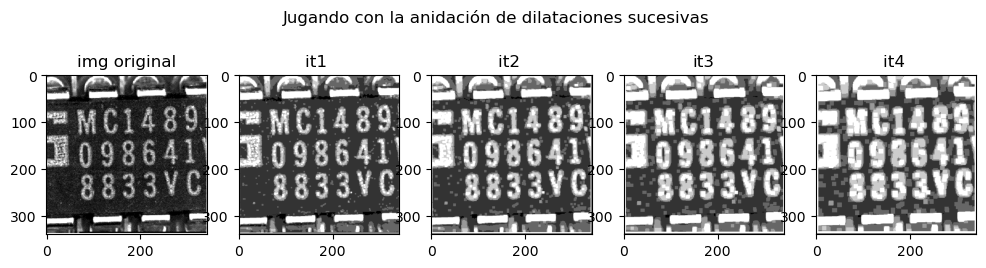

In [4]:
#%% ------------------------------- Dilatación -------------------------------
# Seteo de img, kernel y operación morfologica
img = img_gray;
se = kernel('box',3) > 0;
fcn=np.max # dilatación

# Ploteos
fig,ax=plt.subplots(1,5,figsize=(12,3))
ax[0].imshow(img,'gray'); ax[0].title.set_text('img original')

img_out = conv2d_bin(img,se,fcn)
ax[1].imshow(img_out,'gray'); ax[1].title.set_text('it1 ')

img_out = conv2d_bin(img_out,se,fcn)
ax[2].imshow(img_out,'gray'); ax[2].title.set_text('it2 ')

img_out = conv2d_bin(img_out,se,fcn)
ax[3].imshow(img_out,'gray'); ax[3].title.set_text('it3')

img_out = conv2d_bin(img_out,se,fcn)
ax[4].imshow(img_out,'gray'); ax[4].title.set_text('it4 ')

fig.suptitle('Jugando con la anidación de dilataciones sucesivas');


# Operaciones morfológicas
4. Jugando con la anidación de erosiones sucesivas (fcn=np.min # erosion)

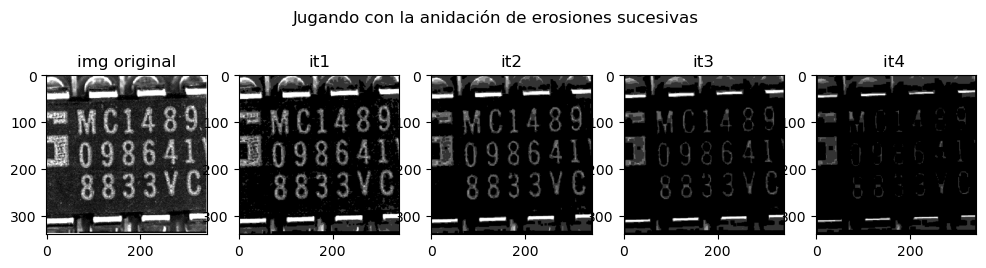

In [5]:
#%% ------------------------------- Erosión -------------------------------
# Seteo de img, kernel y operación morfologica
img = img_gray;
se = kernel('box',3) > 0;
fcn=np.min # erosion

# Ploteos
fig,ax=plt.subplots(1,5,figsize=(12,3))
ax[0].imshow(img,'gray'); ax[0].title.set_text('img original')

img_out = conv2d_bin(img,se,fcn)
ax[1].imshow(img_out,'gray'); ax[1].title.set_text('it1')

img_out = conv2d_bin(img_out,se,fcn)
ax[2].imshow(img_out,'gray'); ax[2].title.set_text('it2')

img_out = conv2d_bin(img_out,se,fcn)
ax[3].imshow(img_out,'gray'); ax[3].title.set_text('it3')

img_out = conv2d_bin(img_out,se,fcn)
ax[4].imshow(img_out,'gray'); ax[4].title.set_text('it4 ')

fig.suptitle('Jugando con la anidación de erosiones sucesivas');

# Operaciones morfológicas
5. Jugando con la anidación de aperturas sucesivas

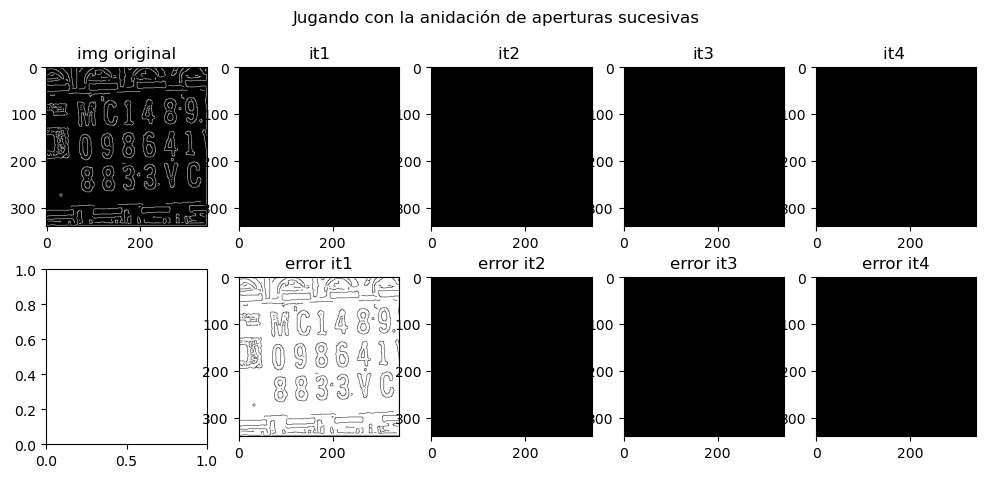

In [6]:
#%% ------------------------------- Apertura -------------------------------
# Seteo de img, kernel y apertura
img = img_gray_chip;
img = img_gray_cam;
img = img_bin1;
se = kernel('box',3) > 0;
fcn_erosion=np.min; fcn_dilatacion=np.max

# Ploteos
fig,ax=plt.subplots(2,5,figsize=(12,5))
ax[0][0].imshow(img,'gray'); ax[0][0].title.set_text('img original')


# Apertura
img_out = conv2d_bin(img,se,fcn_erosion);
img_out = conv2d_bin(img_out,se,fcn_dilatacion);
ax[0][1].imshow(img_out,'gray'); ax[0][1].title.set_text('it1')
ax[1][1].imshow(img_out-img,'gray'); ax[1][1].title.set_text('error it1')

# Apertura
img = img_out;
img_out = conv2d_bin(img,se,fcn_erosion);
img_out = conv2d_bin(img_out,se,fcn_dilatacion);
ax[0][2].imshow(img_out,'gray'); ax[0][2].title.set_text('it2 ')
ax[1][2].imshow(img_out-img,'gray'); ax[1][2].title.set_text('error it2')

# Apertura
img = img_out
img_out = conv2d_bin(img,se,fcn_erosion);
img_out = conv2d_bin(img_out,se,fcn_dilatacion);
ax[0][3].imshow(img_out,'gray'); ax[0][3].title.set_text('it3')
ax[1][3].imshow(img_out-img,'gray'); ax[1][3].title.set_text('error it3')

# Apertura
img = img_out
img_out = conv2d_bin(img,se,fcn_erosion);
img_out = conv2d_bin(img_out,se,fcn_dilatacion);
ax[0][4].imshow(img_out,'gray'); ax[0][4].title.set_text('it4 ')
ax[1][4].imshow(img_out-img,'gray'); ax[1][4].title.set_text('error it4')

fig.suptitle('Jugando con la anidación de aperturas sucesivas');

# Operaciones morfológicas

Borde morfológico

6. Borde exterior (dilatación menos original)
7. Borde interior (original menos erosión)
8. Gradiente (dilatación menos erosión)

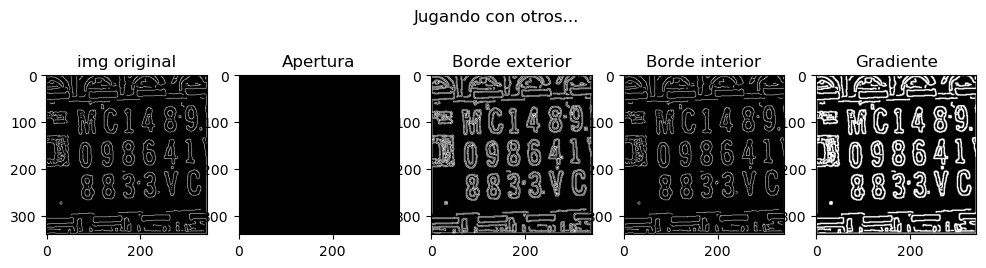

In [7]:
#%% ------------------------------- Otros -------------------------------
# Seteo de img, kernel
img = img_gray_chip;
#img = img_gray_cam;
img = img_bin1;
se = kernel('box',3) > 0;
fcn_erosion=np.min; fcn_dilatacion=np.max

# Ploteos
fig,ax=plt.subplots(1,5,figsize=(12,3))
ax[0].imshow(img,'gray'); ax[0].title.set_text('img original')

# Apertura
img_out = conv2d_bin(img,se,fcn_erosion);
img_out = conv2d_bin(img_out,se,fcn_dilatacion);
ax[1].imshow(img_out,'gray'); ax[1].title.set_text('Apertura')

# Borde exterior (dilatación menos original):
img_out = conv2d_bin(img,se,fcn_dilatacion);
ax[2].imshow(img_out-img,'gray'); ax[2].title.set_text('Borde exterior')

# Borde interior (original menos erosión)
img_out = conv2d_bin(img,se,fcn_erosion);
ax[3].imshow(img-img_out,'gray'); ax[3].title.set_text('Borde interior')

# Gradiente (dilatación menos erosión)
img_out_ero = conv2d_bin(img,se,fcn_erosion);
img_out_dil = conv2d_bin(img,se,fcn_dilatacion);
ax[4].imshow(img_out_dil-img_out_ero,'gray'); ax[4].title.set_text('Gradiente')

fig.suptitle('Jugando con otros...');